In [ ]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.nn.ghostG import GhostGutzwiller
from gGA.utils.tools import setup_seed
from gGA.data.transforms import OrbitalMapper

# setup_seed(1234)

torch.set_default_dtype(torch.float64)
U = 5.5
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=torch.tensor([6, 14]),
    nocc=2,
    basis={"C":[1], "Si":[1]},
    idx_intorb={"C":[0], "Si":[0]},
    naux=3,
    intparams={"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}], "Si":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=2,
    device=torch.device("cpu"),
    kBT=0.0002,
    mutol=1e-7,
    solver="ED",
    mixer_options={"method": "Linear", "a": 0.3},
    iscomplex=True,
    solver_options={}# {"mfepmin":500, "channels": 10},
)

t = -1.
t_ = 0.3
delta = 0.9
tp = - t_ * (1+delta)
tm = - t_ * (1-delta)

block = {
    "0_0_0_0_0": torch.zeros(1,1),
    "1_1_0_0_0": torch.zeros(1,1),
    
    # 1nn for 0
    "0_1_0_0_0": torch.tensor([[t]]),
    "0_1_-1_0_0": torch.tensor([[t]]),
    "0_1_0_-1_0": torch.tensor([[t]]),
    "0_1_-1_-1_0": torch.tensor([[t]]),
    
    # 1nn for 1
    "1_0_0_0_0": torch.tensor([[t]]),
    "1_0_0_1_0": torch.tensor([[t]]),
    "1_0_1_1_0": torch.tensor([[t]]),
    "1_0_1_0_0": torch.tensor([[t]]),

    # 2nn for 0
    "0_0_-1_0_0": torch.tensor([[tp]]),
    "0_0_1_0_0": torch.tensor([[tp]]),
    "0_0_0_1_0": torch.tensor([[tm]]),
    "0_0_0_-1_0": torch.tensor([[tm]]),

    # 2nn for 1
    "1_1_-1_0_0": torch.tensor([[tm]]),
    "1_1_1_0_0": torch.tensor([[tm]]),
    "1_1_0_1_0": torch.tensor([[tp]]),
    "1_1_0_-1_0": torch.tensor([[tp]]),
}

for k in block:
    block[k] = torch.kron(block[k], torch.eye(2))

atomicdata = AtomicData.from_ase(
    read("/nessa/users/zhanghao/dev/Hubbard/gGA/test/am.vasp"),
    r_max=2.7
    )

atoms = atomicdata.to_ase()

atomicdata["kpoint"] = torch.tensor(kmesh_sampling([20,20,1], True)).to(torch.get_default_dtype())
block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)
atomicdata = gga.kinetic.idp_phy(atomicdata)

In [2]:
gga.run(atomicdata, 1000, 1e-5)

DM_kin:  tensor([0.1470, 0.1470, 0.2421, 0.2421, 0.6171, 0.6171, 0.9938, 0.9938])
 -- Current error: 1.52554
DM_kin:  tensor([3.9252e-04, 3.9252e-04, 2.9829e-01, 2.9829e-01, 7.0148e-01, 7.0148e-01,
        9.9984e-01, 9.9984e-01])
 -- Current error: 1.09797
DM_kin:  tensor([4.4811e-04, 4.4811e-04, 2.8842e-01, 2.8842e-01, 7.1127e-01, 7.1127e-01,
        9.9986e-01, 9.9986e-01])
 -- Current error: 0.76588
DM_kin:  tensor([4.2949e-04, 4.2949e-04, 2.7605e-01, 2.7605e-01, 7.2366e-01, 7.2366e-01,
        9.9986e-01, 9.9986e-01])
 -- Current error: 0.53361
DM_kin:  tensor([4.4115e-04, 4.4115e-04, 2.6728e-01, 2.6728e-01, 7.3239e-01, 7.3239e-01,
        9.9988e-01, 9.9988e-01])
 -- Current error: 0.37122
DM_kin:  tensor([4.4934e-04, 4.4934e-04, 2.6008e-01, 2.6008e-01, 7.3958e-01, 7.3958e-01,
        9.9989e-01, 9.9989e-01])
 -- Current error: 0.25762
DM_kin:  tensor([4.5594e-04, 4.5594e-04, 2.5442e-01, 2.5442e-01, 7.4523e-01, 7.4523e-01,
        9.9989e-01, 9.9989e-01])
 -- Current error: 0.178

{'C': tensor([[[ 0.5550+0.0000j,  0.0000+0.0000j, -0.1234+0.0129j,  0.0000+0.0000j,
           -1.2483-0.5751j,  0.0000+0.0000j],
          [ 0.0000+0.0000j,  0.5550+0.0000j,  0.0000+0.0000j, -0.1234+0.0129j,
            0.0000+0.0000j, -1.2483-0.5751j],
          [-0.1234-0.0129j,  0.0000+0.0000j, -2.2955+0.0000j,  0.0000+0.0000j,
            0.7345+0.4364j,  0.0000+0.0000j],
          [ 0.0000+0.0000j, -0.1234-0.0129j,  0.0000+0.0000j, -2.2955+0.0000j,
            0.0000+0.0000j,  0.7345+0.4364j],
          [-1.2483+0.5751j,  0.0000+0.0000j,  0.7345-0.4364j,  0.0000+0.0000j,
            0.9586+0.0000j,  0.0000+0.0000j],
          [ 0.0000+0.0000j, -1.2483+0.5751j,  0.0000+0.0000j,  0.7345-0.4364j,
            0.0000+0.0000j,  0.9586+0.0000j]]])}

In [5]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.nn.ghostG import GhostGutzwiller
from gGA.utils.tools import setup_seed

# setup_seed(1234)

torch.set_default_dtype(torch.float64)
U = 5.5
J = 0. # 0.25 * U
Up = 0. #U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=torch.tensor([6]),
    nocc=2,
    basis={"C":[2]},
    idx_intorb={"C":[0]},
    naux=3,
    intparams={"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=2,
    device=torch.device("cpu"),
    kBT=0.0002,
    mutol=1e-7,
    solver="ED",
    mixer_options={"method": "Linear", "a": 0.3},
    iscomplex=True,
    solver_options={}# {"mfepmin":500, "channels": 10},
)

t = -1.
t_ = 0.3
delta = 0.9
tp = - t_ * (1+delta)
tm = - t_ * (1-delta)

block = {
    "0_0_0_0_0": torch.tensor([[0.,t],[t, 0.]]),
    
    # 1nn for 0
    "0_0_-1_0_0": torch.tensor([[tp,t],[0.,tm]]),
    "0_0_0_-1_0": torch.tensor([[tm,t],[0.,tp]]),
    "0_0_-1_-1_0": torch.tensor([[0.,t],[0.,0.]]),
    "0_0_0_1_0": torch.tensor([[tm,0.],[t,tp]]),
    "0_0_1_1_0": torch.tensor([[0.,0.],[t,0.]]),
    "0_0_1_0_0": torch.tensor([[tp,0.],[t,tm]]),

}

for k in block:
    block[k] = torch.kron(block[k], torch.eye(2))

atomicdata = AtomicData.from_ase(
    read("/nessa/users/zhanghao/dev/Hubbard/gGA/test/am2o.vasp"),
    r_max=3.8
    )

atoms = atomicdata.to_ase()

atomicdata["kpoint"] = torch.tensor(kmesh_sampling([20,20,1], True)).to(torch.get_default_dtype())
block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)

In [6]:
U = 3.5
J = 0.5 * U
Up = 0. # U - 2*J
Jp = 0. # J

gga.update_intparam({"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]})
gga.run(atomicdata, 1000, 1e-5)

DM_kin:  tensor([0.0016, 0.0016, 0.0742, 0.0742, 0.4106, 0.4106, 0.5196, 0.5196, 0.9945,
        0.9945, 0.9996, 0.9996])
 -- Current error: 0.78430
DM_kin:  tensor([0.0068, 0.0068, 0.0428, 0.0428, 0.4290, 0.4290, 0.5231, 0.5231, 0.9985,
        0.9985, 0.9998, 0.9998])
 -- Current error: 0.82593
DM_kin:  tensor([0.0102, 0.0102, 0.0127, 0.0127, 0.4535, 0.4535, 0.5246, 0.5246, 0.9993,
        0.9993, 0.9998, 0.9998])
 -- Current error: 0.58705
DM_kin:  tensor([0.0065, 0.0065, 0.0105, 0.0105, 0.4796, 0.4796, 0.5043, 0.5043, 0.9994,
        0.9994, 0.9997, 0.9997])
 -- Current error: 0.39078
DM_kin:  tensor([0.0048, 0.0048, 0.0098, 0.0098, 0.4762, 0.4762, 0.5100, 0.5100, 0.9995,
        0.9995, 0.9997, 0.9997])
 -- Current error: 0.26695
DM_kin:  tensor([0.0043, 0.0043, 0.0090, 0.0090, 0.4558, 0.4558, 0.5319, 0.5319, 0.9994,
        0.9994, 0.9996, 0.9996])
 -- Current error: 0.19928
DM_kin:  tensor([0.0042, 0.0042, 0.0084, 0.0084, 0.4391, 0.4391, 0.5494, 0.5494, 0.9993,
        0.9993, 0

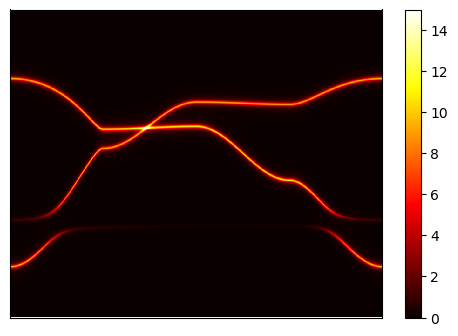

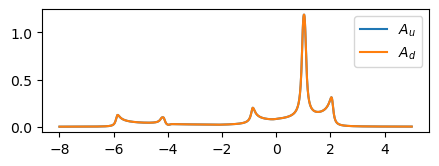

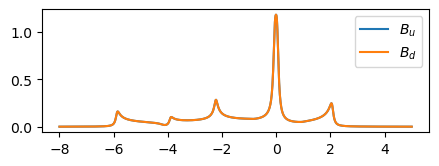

In [3]:
from gGA.utils.make_kpoints import abacus_kpath

kpoints, xpath, _ = abacus_kpath(
    atoms, 
    torch.tensor([
        [0,0,0,200],
        [0.25,0.25,0,200],
        [0.0,0.5,0,200],
        [-0.25,0.25,0,200],
        [0,0,0,1]
    ])
    )

data = atomicdata.copy()
kpoints = torch.from_numpy(kpoints)
kpoints[:,:2] = torch.stack([kpoints[:,:2].sum(-1), kpoints[:,0] - kpoints[:,1]], dim=-1)
data["kpoint"] = kpoints

Es = torch.linspace(-8,5, 1000) + gga.E_fermi
GF = gga.compute_GF(Es=Es, data=data, eta=0.06)
ARPES = -(1/torch.pi)*GF.imag.diagonal(offset=0, dim1=-1, dim2=-2)
pdos = ARPES.sum(0) / ARPES.shape[0]
pdos = pdos.reshape(-1,4)
dos = pdos.sum(-1)
ARPES = ARPES.sum(-1)


import matplotlib.pyplot as plt
ARPES = torch.flip(ARPES, (0,1))
fig, ax = plt.subplots(figsize=(6,4))
m = ax.matshow(ARPES.T, cmap="hot", vmin=0, vmax=15)
ax.set_aspect('auto')  # override the default 'equal'
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(m)
plt.show()

plt.figure(figsize=(5,1.6))
# plt.plot(Es, dos)
plt.plot(Es-gga.E_fermi, pdos[:,:2])
plt.legend([f"$A_u$", f"$A_d$"])
plt.show()
plt.figure(figsize=(5,1.6))
plt.plot(Es-gga.E_fermi, pdos[:,2:])
plt.legend([f"$B_u$",f"$B_d$"])
plt.show()

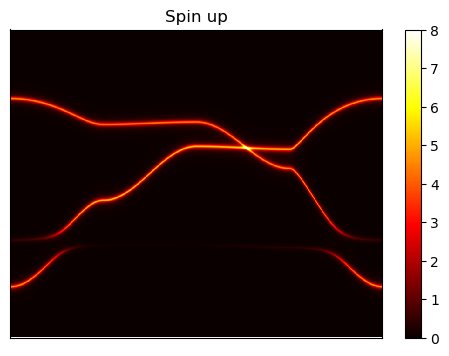

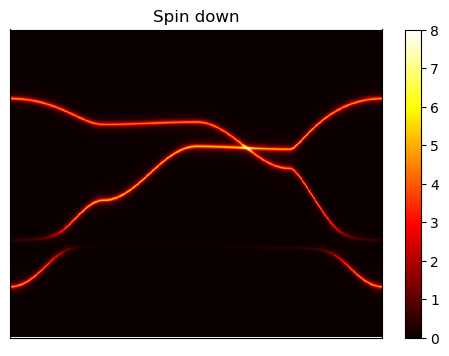

In [4]:
from gGA.utils.make_kpoints import abacus_kpath

kpoints, xpath, _ = abacus_kpath(
    atoms, 
    torch.tensor([
        [0,0,0,200],
        [-0.25,0.25,0,200],
        [0.0,0.5,0,200],
        [0.25,0.25,0,200],
        [0,0,0,1]
    ])
    )

data = atomicdata.copy()
kpoints = torch.from_numpy(kpoints)
kpoints[:,:2] = torch.stack([kpoints[:,:2].sum(-1), kpoints[:,0] - kpoints[:,1]], dim=-1)
data["kpoint"] = kpoints

Es = torch.linspace(-8,5, 1000) + gga.E_fermi
GF = gga.compute_GF(Es=Es, data=data, eta=0.06)
ARPES = -(1/torch.pi)*GF.imag.diagonal(offset=0, dim1=-1, dim2=-2)
# ARPES = ARPES.sum(-1)


import matplotlib.pyplot as plt
ARPES = torch.flip(ARPES, (0,1))
fig, ax = plt.subplots(figsize=(6,4))
m = ax.matshow((ARPES[:,:,0]+ARPES[:,:,2]).T, cmap="hot", vmin=0, vmax=8)
ax.set_aspect('auto')  # override the default 'equal'
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Spin up")
fig.colorbar(m)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
m = ax.matshow((ARPES[:,:,1]+ARPES[:,:,3]).T, cmap="hot", vmin=0, vmax=8)
ax.set_aspect('auto')  # override the default 'equal'
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Spin down")
fig.colorbar(m)
plt.show()

In [66]:
import torch

kpoints = data["kpoint"]
U = 3.5
deltam=0.2

H_up = torch.stack([
    2*tm*torch.cos((kpoints[:,0]+kpoints[:,1])*2*torch.pi)+2*tp*torch.cos((kpoints[:,0]-kpoints[:,1])*2*torch.pi),#-U*deltam,
    2*t*torch.cos(kpoints[:,0]*2*torch.pi) + 2*t*torch.cos(kpoints[:,1]*2*torch.pi),
    2*t*torch.cos(kpoints[:,0]*2*torch.pi) + 2*t*torch.cos(kpoints[:,1]*2*torch.pi),
    2*tp*torch.cos((kpoints[:,0]+kpoints[:,1])*2*torch.pi)+2*tm*torch.cos((kpoints[:,0]-kpoints[:,1])*2*torch.pi),#+U*deltam
    ]).T.reshape(-1,2,2)

H_down = torch.stack([
    2*tm*torch.cos((kpoints[:,0]+kpoints[:,1])*2*torch.pi)+2*tp*torch.cos((kpoints[:,0]-kpoints[:,1])*2*torch.pi),#+U*deltam,
    2*t*torch.cos(kpoints[:,0]*2*torch.pi) + 2*t*torch.cos(kpoints[:,1]*2*torch.pi),
    2*t*torch.cos(kpoints[:,0]*2*torch.pi) + 2*t*torch.cos(kpoints[:,1]*2*torch.pi),
    2*tp*torch.cos((kpoints[:,0]+kpoints[:,1])*2*torch.pi)+2*tm*torch.cos((kpoints[:,0]-kpoints[:,1])*2*torch.pi)#-U*deltam
    ]).T.reshape(-1,2,2)

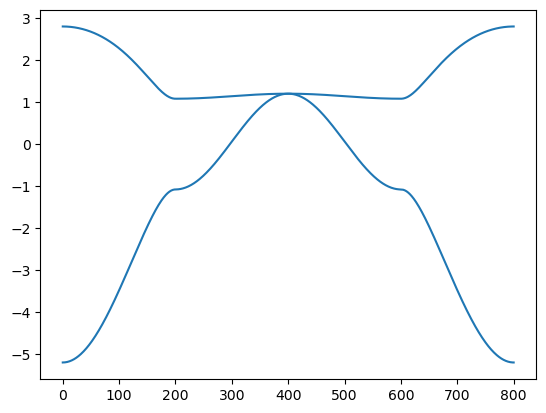

In [69]:
eigvals_up = torch.linalg.eigvalsh(H_up)
# eigvals_down = torch.linalg.eigvalsh(H_down)

plt.plot(eigvals_up, c="tab:blue")
# plt.plot(eigvals_down, c="tab:red")
plt.show()